# Relevant Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

# Week 1

In [66]:
# Generate datapoints
l = 1000
dim = 1
d = np.random.rand(l, dim) * 20 - np.array([[10] for _ in range(l)])
noise = 2 # sigma^2_y
def augment_d(d): # Augments dataset with an intercept column
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
eps = np.random.randn(l) * noise

true_weights = np.array([-9, 15]) # Underlying data-generating weights
y = augment_d(d) @ true_weights + eps

In [67]:
mu_prior = np.array([19, 5])
cov_prior = np.array([[20, 0.3], [0.3, -3]]) * 20

def posterior_distribution(theta, d, y):
    mu = cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return stats.multivariate_normal.pdf(theta, mean=mu, cov=cov)
def get_theta(d, y, mu_prior=mu_prior, cov_prior=cov_prior):
    mu = cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return mu, cov

[-9 15]


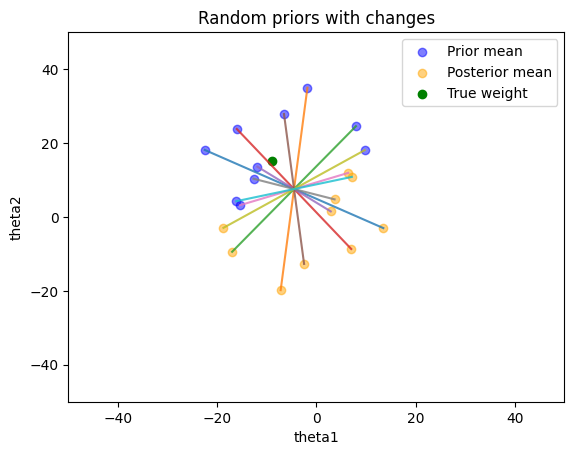

In [68]:
N = 10
print(true_weights)
mu_prior_samples = (np.random.randn(N, 2))*10 + true_weights
cov_prior_samples = np.tile(np.eye(2), (20, 1, 1))
#cov_prior_samples = np.array([np.eye(2, 2) for _ in range(N)])
#mus = np.array([get_theta(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)[0] for mu_prior in mu_prior_samples])
mus = np.array([get_theta(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)[0] for mu_prior, cov_prior in zip(mu_prior_samples, cov_prior_samples)])

#plt.scatter([(eigen[0], eigen[1]) for eigen in np.linalg.eigen(covs)])
for prior, posterior in zip(mu_prior_samples, mus):
    plt.plot([prior[0], posterior[0]], [prior[1], posterior[1]], alpha=0.8)
plt.scatter(mu_prior_samples[:, 0], mu_prior_samples[:, 1], color="blue", label="Prior mean", alpha=0.5)
plt.scatter(mus[:, 0], mus[:, 1], color="orange", label="Posterior mean", alpha=0.5)
plt.scatter(true_weights[0], true_weights[1], color="green", label="True weight")
plt.xlim(-50, 50)
plt.ylim(-50,50)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("Random priors with changes")
plt.legend()